Here we will perform Topic modelling on the text obtained from Wikipedia atricles using wikipedia API.
To visualize our topic models, we will make use of pyLDAvis library.

## Scraping Wikipedia Articles

Here, we will use pages of 4 articles of wikipedia - "Climate Change", "AI", "Mona Lisa" and "Eiffel Tower".
Calling their content, we will prepare our corpus.

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
#Scrapping Wikipedia articles
import wikipedia
import nltk

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

global_warming = wikipedia.page("Climate Change")
artificial_intelligence = wikipedia.page("Artificial Intelligence")
mona_lisa = wikipedia.page("Mona Lisa")
eiffel_tower = wikipedia.page("Eiffel Tower")

corpus = [global_warming.content, artificial_intelligence.content, mona_lisa.content, eiffel_tower.content]
# corpus[1]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\infom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the above script, we will import wikipedia and nltk libraries. We are also downloading stopwords from english
nltk stopwords. These will be used in our tasks ahead. Next, we will download the articles from wikipedia by
specifying the topic to the page object of wikipedia library. The object returns the contained information in downloaded page.

To retrieve the information, we use "content" attribute. Then, we store the content of all four articles in a list named corpus.

## Data Preprocessing 

To perform topic modelling using LDA, we need to have a data dictionary and bag of words corpus.To create these, we need data in the form of tokens.

Also, we need to preprocessed data free of punctuations and stop words from our dataset. Also, for uniformaity, we will convert all our tokens to lowercase and will also lemmatize them. 

In [39]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word)  > 5]

        return tokens

So, we created a method preprocess_text that accepts a text document as a parameter. The method uses regex operations to perform a variety of tasks. 
1. The r'\W' expression replaces all the special characters and numbers by a space.  
2. r'\s+[a-zA-Z]\s+ - when we remove punctuations, single characters with no meaning are there. Eg. Eeffel's -> Eiffel s. Here, s has no meaning, therefore, we need to replace it by a space.However, this removes the single character within the text only.
3. '\s+' - Now, we need to remove mutliple whitespaces developed, so, we will use this expression for that.
4. '^b\s+' - When we scrap a document online, a string b appears. It signifies that the document is binary. To remove that, we will use this.
5. The document is then converted to lowerspace.
6. It will be split and lemmatized, and checked for stop words and considered suitable if len(word) > 5.

In [40]:
processed_data = [];
for doc in corpus:
    tokens = preprocess_text(doc)
    processed_data.append(tokens)

Now, we tokenize our documents using thr preprocess_text function and then form out our preprocessed_text.

In the script below, we import corpora from gensim and form a dictionary using the preprocessed_data in the form of word_Id and and lemmatized words. With that, we create our bag of words. The corpus will update itself (allow_update = True) by adding new tokens from document



In [41]:
from gensim import corpora

gensim_dictionary = corpora.Dictionary(processed_data)
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in processed_data]

Now, we will save our dictionary and bag of words using pickle library. These saved models will be used to make predictions on the new data.

In [42]:
import pickle

pickle.dump(gensim_corpus, open('gensim_corpus_corpus.pkl', 'wb'))
gensim_dictionary.save('gensim_dictionary.gensim')

Now, with preprocessing done, we will use LdaModel class from gensim.models.ldamodel module to create the LDA model.
We need to pass the BOW corpus that we earlier created as our first parameter to the LdaModel constructor, followed by the number of topics, the dictionary that we created earlier and passes(number of iterations for the model) to train our model on the corpus 20 times.

Then, we will save our model.

In [43]:
import gensim

lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=4, id2word=gensim_dictionary, passes=20)
lda_model.save('gensim_model.gensim')

Now, with our model trained, we can use print_topics method to print 10 models. 

In [44]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.019*"intelligence" + 0.015*"machine" + 0.014*"artificial" + 0.011*"system" + 0.011*"problem" + 0.008*"knowledge" + 0.008*"research" + 0.006*"approach" + 0.006*"learning" + 0.006*"computer"')
(1, '0.032*"climate" + 0.023*"change" + 0.017*"warming" + 0.015*"emission" + 0.013*"global" + 0.011*"greenhouse" + 0.010*"carbon" + 0.009*"energy" + 0.008*"temperature" + 0.007*"increase"')
(2, '0.000*"climate" + 0.000*"change" + 0.000*"warming" + 0.000*"painting" + 0.000*"eiffel" + 0.000*"emission" + 0.000*"global" + 0.000*"system" + 0.000*"intelligence" + 0.000*"greenhouse"')
(3, '0.021*"painting" + 0.017*"eiffel" + 0.010*"leonardo" + 0.007*"french" + 0.006*"second" + 0.006*"louvre" + 0.005*"portrait" + 0.005*"century" + 0.004*"original" + 0.004*"million"')


We can see that - 
Topic 0 - It is related to AI, research and machine - so, it has AI connection.
Topic 1 - It relates to painting, french, leonardo - It is connected to France.
Topic 2 - It relates to climate, change, warming - It is concerned with Global Warming.
Topic 3 - It seem a new topic. 


As LDA is an unsupervised learning algorithm, in real world datasets, we won't be knowing about the topics in advance as we have here.With the given corpu, topics will be generated by LDA and we decide what the topic is about.

- Now, Lets create 8 topics, using our saved model.We will print 5 keywords in this case.

In [45]:
lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=8, id2word=gensim_dictionary, passes=15)
lda_model.save('gensim_model.gensim')
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.000*"climate" + 0.000*"change" + 0.000*"painting" + 0.000*"eiffel" + 0.000*"emission"')
(1, '0.021*"intelligence" + 0.016*"machine" + 0.015*"artificial" + 0.012*"system" + 0.012*"problem"')
(2, '0.001*"painting" + 0.000*"leonardo" + 0.000*"louvre" + 0.000*"portrait" + 0.000*"climate"')
(3, '0.036*"climate" + 0.026*"change" + 0.019*"warming" + 0.016*"emission" + 0.015*"global"')
(4, '0.032*"eiffel" + 0.009*"second" + 0.008*"french" + 0.007*"exposition" + 0.007*"structure"')
(5, '0.000*"climate" + 0.000*"change" + 0.000*"eiffel" + 0.000*"warming" + 0.000*"machine"')
(6, '0.000*"climate" + 0.000*"change" + 0.000*"eiffel" + 0.000*"emission" + 0.000*"global"')
(7, '0.044*"painting" + 0.021*"leonardo" + 0.011*"louvre" + 0.011*"portrait" + 0.008*"century"')


The number of topics we create is upto us. If we train our data on the saved model again with num_topics as 8 and num_keywords as 10, we will get different results since the initial values of LDA parameters are chosen randomly.Because LDA uses randomness in training due to its probabilistic nature.
We can solve it using np.random.seed(SOME_FIXED_SEED). eg. random_state=np.random.RandomState(seed=10101010) as a parameter.

In [50]:
lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=4, id2word=gensim_dictionary, passes=20)
lda_model.save('gensim_model.model')
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.019*"intelligence" + 0.015*"machine" + 0.014*"artificial" + 0.011*"system" + 0.011*"problem" + 0.008*"research" + 0.008*"knowledge" + 0.006*"approach" + 0.006*"learning" + 0.006*"computer"')
(1, '0.036*"painting" + 0.017*"leonardo" + 0.009*"louvre" + 0.009*"portrait" + 0.006*"century" + 0.006*"french" + 0.006*"museum" + 0.005*"italian" + 0.005*"giocondo" + 0.004*"subject"')
(2, '0.027*"eiffel" + 0.008*"second" + 0.006*"french" + 0.006*"structure" + 0.006*"exposition" + 0.005*"tallest" + 0.005*"engineer" + 0.004*"design" + 0.004*"million" + 0.004*"france"')
(3, '0.032*"climate" + 0.023*"change" + 0.017*"warming" + 0.015*"emission" + 0.013*"global" + 0.011*"greenhouse" + 0.010*"carbon" + 0.009*"energy" + 0.008*"temperature" + 0.007*"increase"')


Now, we can see that the words in 1st topic are related to chimate change and 2nd topic to chimate change too.

# Evaluating the LDA Model

Unsupervised learning modelsa are hard to evaluate due to lack of concrete label against it to test the output.

Now, with our test document, we can find its topics using LDA model we just created. 

In [47]:
test_doc = 'Great structures are build to remember an event happened in the history.'
test_doc = preprocess_text(test_doc)
bow_test_doc = gensim_dictionary.doc2bow(test_doc)

print(lda_model.get_document_topics(bow_test_doc))

[(0, 0.084051505), (1, 0.084622286), (2, 0.08337391), (3, 0.7479523)]


In the above script, we created a string, then we tokenized it for dictionary representation and then we convered the string to bag of words. The bag of words representation is then passed to get_document_topics. It returns the topic distribution for a given document.

The output shows that there is 8.3 % chance that the document belongs topic 1, Similarly, there is 74% chance that the document belongs to topic 3.Our topic 3. Our 3rd topic is about French painting and Eiffel tower.

## Perplexity and Coherence Score

Another way to evaluate our model us using Perplexity and Coherence Score.
Perplexity in general terms means confusion or complexity. If it is lower, the better.It takes bag of words corpus as parameter. 
Coherence means similarity, It is higher, the better. CoherenceModel class takes the LDA model, the tokenized text, the dictionary, and 'c_v'(for this text sshould be provided, it can do without corpus) 

In [48]:
print('\nPerplexity:', lda_model.log_perplexity(gensim_corpus))

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(model=lda_model, texts=processed_data, dictionary=gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)


Perplexity: -7.551714383505902

Coherence Score: 0.5529160225896275


## Visualizing the LDA

To visualize our data, we use pyLDAvis library.This library contains a module for Gensim LDA model. We first need to prepare the visualization by passing the dictionary, a bag of words corpus, and lda model. Using there parameters, we call prepare method and then call the display on the gensim module of the pyLDAvis library.



In [51]:
gensim_dictionary = gensim.corpora.Dictionary.load('gensim_dictionary.gensim')
gensim_corpus = pickle.load(open('gensim_corpus_corpus.pkl', 'rb'))
lda_model = gensim.models.ldamodel.LdaModel.load('gensim_model.model')

import pyLDAvis.gensim

lda_visualization = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

Here, Each circle in the above image corrosponds to one topic. From the output of the LDA model, using four topics, we know what the topics are about.

The distance beteen the circles shows how different the topics are. If the circles overlap, it means the topics are close to each other. It can be due to similarity of words used in the topics. 
T
The words on the RHS provide the 30 most used words(frequency). If we hover on the words, They inform us of which topic or topics they belong to and other topics disappear. 
If we hover our mouse on the circles, they provide us with which words are most frequent in them.



This way we can evaluate our model 

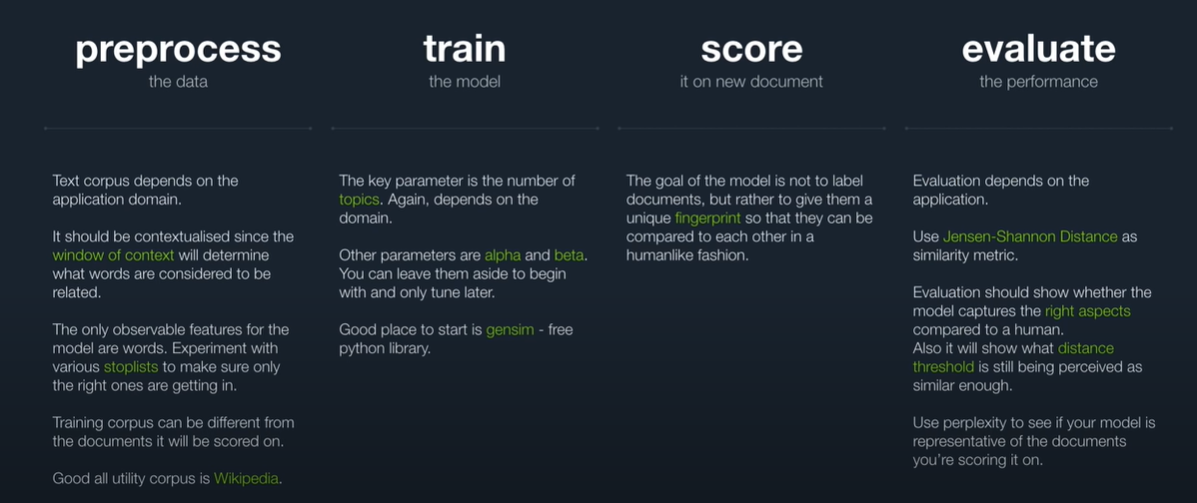



